In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

In [76]:
filepath = r'voltage_diff\1 kv.Spe'
counts = np.loadtxt(filepath)
bins = np.array(range(1,1+np.size(counts)))

In [77]:
peak_indices, peak_dict = sc.signal.find_peaks(counts, prominence = 1e2, height=4000, width=40)
peak_heights = peak_dict['peak_heights']
peaks = [peak_indices[np.argmax(peak_heights)], peak_indices[np.argpartition(peak_heights,-2)[-2]]]
num = np.size(peaks)

print(peaks)

[np.int64(2378), np.int64(2705)]


In [78]:
width = 100

def gaussian(x, amp, mean, std_dev):
    return amp * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

param_array = np.zeros((num,3))
covariance_array = np.zeros((num,4))
fitted_gaussians = np.zeros((num,width*2))
fwhm_array = np.zeros((num,1))


for c in range(0, num):
    initial_guess = [counts[peaks[c]],peaks[c], 1]
    popt, pcov = sc.optimize.curve_fit(gaussian, bins[peaks[c]-width:peaks[c]+width], counts[peaks[c]-width:peaks[c]+width], p0=initial_guess)

    popt[1:] = popt[1:]*4.882741E-001
    param_array[c] = popt
    covariance_array[c] = [np.linalg.cond(pcov), *np.diag(pcov)]
    fitted_gaussians[c] = gaussian(bins[peaks[c]-width:peaks[c]+width], *popt)
    fwhm_array[c] = 2 * np.sqrt(2 * np.log(2)) * popt[2]

    print(f"Peak {c+1}:")
    print(f"  Amplitude = {popt[0]:.2f}, Mean = {popt[1]:.2f} keV, Std Dev = {popt[2]:.2f} keV")
    print(f"  FWHM = {fwhm_array[c][0]:.2f} keV")
    print(f"  Covariance Condition Number = {covariance_array[c][0]:.2e}")
    print(f"  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = {covariance_array[c][1]:.2e}, {covariance_array[c][2]:.2e}, {covariance_array[c][3]:.2e}")
    print("--------------------------------------------------------------")


Peak 1:
  Amplitude = 15047.63, Mean = 1163.56 keV, Std Dev = 8.21 keV
  FWHM = 19.33 keV
  Covariance Condition Number = 9.02e+05
  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = 6.34e+04, 1.05e-01, 1.05e-01
--------------------------------------------------------------
Peak 2:
  Amplitude = 11469.27, Mean = 1324.65 keV, Std Dev = 8.40 keV
  FWHM = 19.78 keV
  Covariance Condition Number = 5.00e+05
  Covariance Diagonal (Variance of Amplitude, Mean, Std Dev) = 1.64e+04, 4.92e-02, 4.92e-02
--------------------------------------------------------------


In [79]:
c=0
gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]

np.float64(7523.816806054107)

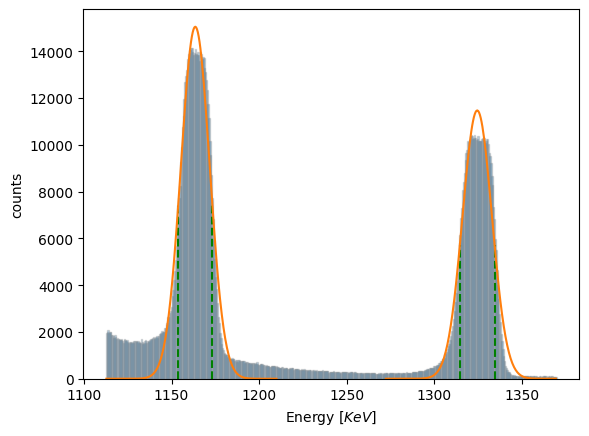

In [80]:
d=100
energy = bins*4.882741E-001

plt.bar(energy[min(peaks)-d:max(peaks)+d], counts[min(peaks)-d:max(peaks)+d], edgecolor='grey', alpha = 0.3)
[plt.plot([param_array[c][1]-fwhm_array[c]/2,param_array[c][1]-fwhm_array[c]/2], [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'g') for c in range(0,num)]
[plt.plot([param_array[c][1]+fwhm_array[c]/2,param_array[c][1]+fwhm_array[c]/2], [0, gaussian(param_array[c][1]-fwhm_array[c]/2, *param_array[c])[0]],linestyle = '--', c = 'g') for c in range(0,num)]
[plt.plot(energy[peaks[c]-width:peaks[c]+width], gaussian(energy[peaks[c]-width:peaks[c]+width], *param_array[c]), c='tab:orange') for c in range(0, num)]

plt.xlabel(r'Energy [$KeV$]')
plt.ylabel('counts')
plt.show()